In [1]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings(action='ignore')
import nltk
#nltk.download('all') # 처음 실행 시 주석을 제거하고 실행해주세요!

In [2]:
from tqdm import tqdm


In [3]:
df = pd.read_excel('news_label.xlsx', engine='openpyxl')

In [4]:
df = df.rename(columns={'dates':'date', 'titles':'title','contents':'content'})
df['content'] = df['title'] + df['content']

In [5]:
df = df.drop(columns=['근거', 'title'])

In [6]:
train = df[:167]
train

,date,content,label
0,2021.10.05,[[톡톡 이상품] 한빛코리아 / 다지워 네이처 클렌징 솝]//[\n마스카라까지 지우...,0
1,2021.10.07,"[[격동의 유통가④]편의점 성장 정체…미래는 근거리 쇼핑]//[""파괴적 커머스 시대...",1
2,2021.10.08,[株머니 매니저의 HOT종목]//[\n\n\n\n\n 씨에스윈드는 풍력발전기를 구성...,1
3,2021.10.11,"[김민수 더맘마 대표 ""동네마트와 '상생'이 경쟁력…30분 총알배송 목표""]//[\...",0
4,2021.10.13,"[""카카오 보고있나""…진격의 네이버페이, 中 최대 직구몰 손잡았다]//[[주간투자동...",1
...,...,...,...
162,2022.04.22,"[NH투자증권, SK에코플랜트 주관사 선정… IPO 실적 호조]//[우리생협, 오아...",-1
163,2022.04.25,[“500억 투자했는데”... 홍정국의 아픈 손가락 ‘헬로네이처’ 매각 적신호]//...,1
164,2022.04.26,"[오아시스마켓 ""오프라인 매장 간판서 '생협' 제외""]//[[고고IPO] ‘업계 4...",1
165,2022.04.27,[[마켓인]프롭테크하면 무조건 뜬다?…투자유치 '부익부 빈익빈']//[IPO 앞둔 ...,-1


In [7]:
# test set
test = df[167:]
test

,date,content,label
167,2022.04.29,"[공정위, 새벽배송업체 오아시스 ‘생협 간판’ 사용에 제동]//[""무조건 창업 한번...",-
168,2022.04.30,[코로나 엔데믹 전환에 배송전쟁 판도 변화…점유율 경쟁 보다 ‘수익성’]//[\n롯...,-
169,2022.05.02,[창업자 188명 '지상 IR' 날개…K-스타트업 등용문 '우뚝']//[오아시스마켓...,-
170,2022.05.03,"[[엔데믹, 오다]이커머스 '옥석 가리기' 본격 시동]//[우여곡절 끝에 IPO 첫...",-
171,2022.05.04,[9조 원 규모 새벽배송 누가 살아남을까? 돈의 전쟁이 시작됐다!]//[\n\t\t...,-
...,...,...,...
274,2022.09.23,"[WCP 흥행 실패에 컬리, 케이뱅크 상장 시기 '안갯속']//[\n심사 승인 났는...",-
275,2022.09.26,"[[먹거리+IT] 네이처랩 오경주 대표, “맛있고 건강한 주스 추천 서비스를 개발합...",-
276,2022.09.27,"[""투자 늘렸는데 이제와서…"" 퀵커머스마저 규제하나 '초긴장']//[\n■국감 오르...",-
277,2022.09.29,[국내 이커머스 상장 1호 주인공 누가될까 [격변의 이커머스①]]//[\n이커머스 ...,-


### 학습/검증셋 분리

In [8]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train)
train.reset_index(inplace=True) # 전처리 과정에서 데이터가 뒤섞이지 않도록 인덱스를 초기화해주었습니다.
val.reset_index(inplace=True)

In [10]:
### train.set_index('date')

train = train.drop(columns = ['index'])
train

,date,content,label
0,2022.01.26,[유통주 추풍낙엽에...상장 앞둔 SSG닷컴·컬리·오아시스 ‘난감’]//[플레이어로...,-1
1,2021.12.01,"[[단독] '몸값 10조' 현대오일뱅크 이달 상장 작업 개시]//[마켓컬리, 250...",1
2,2022.02.15,"[조정석 vs 로제·여진구…대형마트, 광고전 불붙었다]//[\n롯데마트 20년만 첫...",0
3,2022.04.12,"[새벽배송 1호 컬리, 목표 시총 6조지만…거품 논란도]//[케이뱅크, MZ세대 맞...",-1
4,2022.01.04,"[상장 앞둔 오아시스마켓, 재무전문가 안준형 대표이사 선임]//[[이건호 칼럼] 美...",1
...,...,...,...
120,2021.12.30,"[""대박 미리 잡자"" 비상장주식 올라탄 MZ세대…야놀자 243% 급등]//[""코로나...",1
121,2021.12.24,"[[2021 유통결산]①이커머스 '치킨게임', 그 결말은]//[[株머니 주요산업 증...",1
122,2022.04.16,"[“출혈경쟁 피하자” 유통업체들, 잇따른 ‘새벽배송’ 철수]//[[트렌D] 못생기면...",0
123,2022.01.02,[2022년 ‘IPO 대어’ 몰려온다…LG에너지솔루션·현대엔지니어링·쓱닷컴 상장 ...,1


In [51]:
val

,date,content,label,tokenized_stem,main_pos
0,2022.03.27,지어소프트 대구에 이차전지 공장 설립 지어솔루션 대구에 원통형 2차전지 소재공장 ...,1,지다 소프트 대구 에 이차전지 공장 설립 지다 솔루션 대구 에 원통 형 2 차다 소...,지어 소프트 대구 이차전지 공장 설립 지어 솔루션 대구 원통 차전지 소재 공장 건립...
1,2022.02.19,20년만에 매각되는 초록마을 이마트에브리데이 컬리도 인수 군침 유통사부터 스타트업...,1,20년 만에 매각 되다 초록 마을 이마트 에브리데이 컬리 도 인수 군침 유통 사 부...,매각 되는 초록 마을 이마트 에브리데이 컬리 인수 군침 유통 사 스타트업 가지 곳 ...
2,2022.02.14,오아시스마켓 퀵커머스 비신선 오프라인으로 영토 확장 오아시스마켓 소상공인 라방 진...,1,오아시스 마켓 퀵 커머스 비 신선 오프라인 으로 영토 확장 오아시스 마켓 소상 공인...,오아시스 마켓 퀵 커머스 비 신선 오프라인 영토 확장 오아시스 마켓 소상 공인 방 ...
3,2022.04.06,딱 하나만 파는 버티컬커머스 전문성 무기로 소비자 마음 잡았다 코로나 특수 유통업...,1,딱 하나 만 팔다 버티다 컬 커머스 전문성 무기 로 소비자 마음 잡다 코로나 특수 ...,딱 하나 파는 버티 컬 커머스 전문성 무기 소비자 마음 잡았다 코로나 특수 유통업체...
4,2021.11.29,마켓인 밸류업 올인 이머커스 3대장 IPO 앞두고 몸집 키우기 새벽배송 이커머스 ...,1,마켓 인 밸류업 올인 이머커스 3 대장 IPO 앞두다 몸집 키우다 새벽 배송 이커머...,마켓 밸류업 올인 이머커스 대장 앞두고 몸집 키우기 새벽 배송 이커머스 대장 동시 ...
5,2022.03.18,시그널 대상 임세령 임상민 자매 초록마을 매각 수혜 독점 마켓인사이트 식음료 투자...,1,시그널 대상 임세령 임 상민 자매 초록 마을 매각 수혜 독점 마켓 인사이트 식 음료...,시그널 대상 임세령 임 상민 자매 초록 마을 매각 수혜 독점 마켓 인사이트 식 음료...
6,2021.11.05,상장 추진 컬리 SSG 오아시스 벌써 신경전 동네슈퍼도 퀵커머스 가능해질까 법안 ...,1,상장 추진 컬리 SSG 오아시스 벌써 신 경전 동 네 슈퍼 도 퀵 커머스 가능하다 ...,상장 추진 컬리 오아시스 벌써 경전 슈퍼 퀵 커머스 가능해질 까 법안 발의 오아시스...
7,2022.04.10,새벽배송 기업 중 유일하게 흑자내는 오아시스 물류센터에 가보니 대기업 스타트업 퀵...,1,새벽 배송 기업 중 유일하다 흑자 내다 오아시스 물류 센터 에 가보다 대기업 스타트...,새벽 배송 기업 중 유일하게 흑자 내는 오아시스 물류 센터 가보니 대기업 스타트업 ...
8,2022.03.25,위클리 마켓 시장 부진에 4월 중순까지 IPO 전무 두달 만에 IPO 대어들 온다...,1,위 클리 마켓 시장 부진 에 4월 중순 까지 IPO 전무 두 달 만에 IPO 대다 ...,위 클리 마켓 시장 부진 중순 전무 달 대어 들 온다 코스피 안팎 오가면 모주 시장...
9,2021.12.21,내년 IPO시장 후끈 초대어급 줄상장 예고 이슈플러스 민지리뷰 띵동 건강한 유기농...,1,내년 IPO 시장 후끈 초대 어 급 줄 상장 예고 이슈 플러스 민지 리뷰 띵동 건강...,내년 시장 후끈 초대 급 줄 상장 예고 이슈 플러스 민지 리뷰 띵동 건강한 유기농 ...


### 데이터 정제하기

In [12]:
# 문자 외의 것들 제거
train['content'] = train['content'].str.replace('[^가-힣a-zA-Z0-9_]',' ')
# 혹시 모를 다중 공백 제거
train['content'] = train['content'].str.replace(' +',' ') 
train

,date,content,label
0,2022.01.26,유통주 추풍낙엽에 상장 앞둔 SSG닷컴 컬리 오아시스 난감 플레이어로 뛰어든 배달...,-1
1,2021.12.01,단독 몸값 10조 현대오일뱅크 이달 상장 작업 개시 마켓컬리 2500억원 규모 프...,1
2,2022.02.15,조정석 vs 로제 여진구 대형마트 광고전 불붙었다 롯데마트 20년만 첫 TV광고 ...,0
3,2022.04.12,새벽배송 1호 컬리 목표 시총 6조지만 거품 논란도 케이뱅크 MZ세대 맞춤형 케이...,-1
4,2022.01.04,상장 앞둔 오아시스마켓 재무전문가 안준형 대표이사 선임 이건호 칼럼 델라웨어 가 ...,1
...,...,...,...
120,2021.12.30,대박 미리 잡자 비상장주식 올라탄 MZ세대 야놀자 243 급등 코로나19 기회 못...,1
121,2021.12.24,2021 유통결산 이커머스 치킨게임 그 결말은 머니 주요산업 증시기상도 전기차시장...,1
122,2022.04.16,출혈경쟁 피하자 유통업체들 잇따른 새벽배송 철수 트렌D 못생기면 어때 가치소비에 ...,0
123,2022.01.02,2022년 IPO 대어 몰려온다 LG에너지솔루션 현대엔지니어링 쓱닷컴 상장 예고 ...,1


<AxesSubplot:>

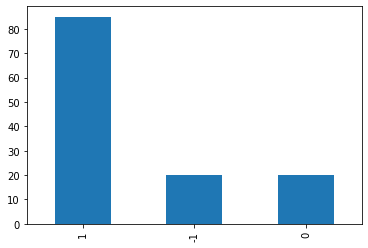

In [13]:
train['label'].value_counts().plot(kind='bar')

### 토큰화

In [14]:
from konlpy.tag import Okt

In [15]:
okt = Okt()

In [16]:
tokenized = [] # 데이터프레임의 한 컬럼으로 추가할 리스트
for sentence in train['content']: # 전처리된 리뷰들을 하나씩 꺼내옵니다
    tokens = okt.morphs(sentence, stem = True) # 형태소 분석 (stem = True로 설정해 어간 추출을 해주었습니다)
    tokenize = " ".join(tokens) # tokens라는 리스트 안의 형태소들을 띄어쓰기로 분리된 하나의 문자열로 join시켜줍니다.
    tokenized.append(tokenize) # 형태소 단위로 띄어쓰기된 문자열을 최종 리스트에 추가해줍니다
train["tokenized_stem"] = pd.DataFrame(tokenized) # 리스트를 데이터프레임으로 변환해 tokenized_stem라는 컬럼명으로 추가해줍니다.

train.head() # 데이터 확인

,date,content,label,tokenized_stem
0,2022.01.26,유통주 추풍낙엽에 상장 앞둔 SSG닷컴 컬리 오아시스 난감 플레이어로 뛰어든 배달...,-1,유통 주 추풍낙엽 에 상장 앞두다 SSG 닷컴 컬리 오아시스 난감 플레이어 로 뛰어...
1,2021.12.01,단독 몸값 10조 현대오일뱅크 이달 상장 작업 개시 마켓컬리 2500억원 규모 프...,1,단독 몸값 10조 현 대 오 일 뱅크 이 달 상장 작업 개시 마켓 컬리 2500억원...
2,2022.02.15,조정석 vs 로제 여진구 대형마트 광고전 불붙었다 롯데마트 20년만 첫 TV광고 ...,0,조정석 vs 로제 여진구 대형 마트 광고 전 불 붙다 롯데 마트 20년 만 첫 TV...
3,2022.04.12,새벽배송 1호 컬리 목표 시총 6조지만 거품 논란도 케이뱅크 MZ세대 맞춤형 케이...,-1,새벽 배송 1 호 컬리 목표 시 총 6조 지만 거품 논란 도 케이 뱅크 MZ 세대 ...
4,2022.01.04,상장 앞둔 오아시스마켓 재무전문가 안준형 대표이사 선임 이건호 칼럼 델라웨어 가 ...,1,상장 앞두다 오아시스 마켓 재무 전문가 안준형 대표이사 선임 이건호 칼럼 델라웨어 ...


### 품사 태깅 / 불용어 처리와 비슷한 느낌

In [17]:
main_pos = [] # 데이터프레임의 새 컬럼이 될 리스트
for sentence in train['content']: # 리뷰들을 하나씩 가져옵니다
    pos = okt.pos(sentence) # 형태소 분석을 진행하고 해당 리스트를 pos라는 변수로 받습니다
    main_words = [word_pos[0] for word_pos in pos if word_pos[1] in ("Noun", "Adverb", "Adjective", "Verb")] # 가져오고자 하는 품사에 해당하면 해당 형태소를 main_words 리스트에 추가합니다.
    main_words_str = " ".join(main_words) # main_words 리스트 안의 형태소들을 띄어쓰기로 분리된 하나의 문자열로 join시켜줍니다.
    main_pos.append(main_words_str) # 선택한 형태소들로 이루어진 문자열을 최종 리스트에 추가해줍니다
train["main_pos"] = pd.DataFrame(main_pos) # 리스트를 데이터프레임으로 변환해 main_pos라는 컬럼명으로 추가해줍니다.

train.head() # 데이터 확인

,date,content,label,tokenized_stem,main_pos
0,2022.01.26,유통주 추풍낙엽에 상장 앞둔 SSG닷컴 컬리 오아시스 난감 플레이어로 뛰어든 배달...,-1,유통 주 추풍낙엽 에 상장 앞두다 SSG 닷컴 컬리 오아시스 난감 플레이어 로 뛰어...,유통 주 추풍낙엽 상장 앞둔 컬리 오아시스 난감 플레이어 뛰어든 배달 업체 바로 유...
1,2021.12.01,단독 몸값 10조 현대오일뱅크 이달 상장 작업 개시 마켓컬리 2500억원 규모 프...,1,단독 몸값 10조 현 대 오 일 뱅크 이 달 상장 작업 개시 마켓 컬리 2500억원...,단독 몸값 뱅크 달 상장 작업 개시 마켓 컬리 규모 프리 소식 관련 도 급등 단독 ...
2,2022.02.15,조정석 vs 로제 여진구 대형마트 광고전 불붙었다 롯데마트 20년만 첫 TV광고 ...,0,조정석 vs 로제 여진구 대형 마트 광고 전 불 붙다 롯데 마트 20년 만 첫 TV...,조정석 로제 여진구 대형 마트 광고 전 불 붙었다 롯데 마트 첫 광고 홈플러스 주도...
3,2022.04.12,새벽배송 1호 컬리 목표 시총 6조지만 거품 논란도 케이뱅크 MZ세대 맞춤형 케이...,-1,새벽 배송 1 호 컬리 목표 시 총 6조 지만 거품 논란 도 케이 뱅크 MZ 세대 ...,새벽 배송 호 컬리 목표 총 거품 논란 케이 뱅크 세대 맞춤 케이 뱅크 롯데 카드 ...
4,2022.01.04,상장 앞둔 오아시스마켓 재무전문가 안준형 대표이사 선임 이건호 칼럼 델라웨어 가 ...,1,상장 앞두다 오아시스 마켓 재무 전문가 안준형 대표이사 선임 이건호 칼럼 델라웨어 ...,상장 앞둔 오아시스 마켓 재무 전문가 안준형 대표이사 선임 이건호 칼럼 델라웨어 가...


### 벡터화

In [20]:
X_train = train.main_pos # training 데이터에서 문서 추출
y_train = train.label # training 데이터에서 라벨 추출

In [21]:
X_train

0      유통 주 추풍낙엽 상장 앞둔 컬리 오아시스 난감 플레이어 뛰어든 배달 업체 바로 유...
1      단독 몸값 뱅크 달 상장 작업 개시 마켓 컬리 규모 프리 소식 관련 도 급등 단독 ...
2      조정석 로제 여진구 대형 마트 광고 전 불 붙었다 롯데 마트 첫 광고 홈플러스 주도...
3      새벽 배송 호 컬리 목표 총 거품 논란 케이 뱅크 세대 맞춤 케이 뱅크 롯데 카드 ...
4      상장 앞둔 오아시스 마켓 재무 전문가 안준형 대표이사 선임 이건호 칼럼 델라웨어 가...
                             ...                        
120    대박 미리 잡자 비상 주식 올라탄 세대 놀자 급등 코로나 기회 못 살렸다 글로벌 순...
121    유통 결산 이커머스 치킨게임 그 결말 머니 산업 증시 기상도 전기차 시장 본격 공략...
122    출혈 경쟁 피하 유통업체 잇따른 새벽 배송 철수 트렌 생기면 어때 가치 소비 못난이...
123    대어 몰려온다 에너지 솔루션 현대 엔지니어링 쓱 상장 예고 올해 시장 뜨거울 듯 엔...
124    구국 가산 단 차전지 핵심 소재 기업 온다 이마트 오아시스 출격 퀵 커머스 경쟁 본...
Name: main_pos, Length: 125, dtype: object

In [27]:
y_train

0      -1
1       1
2       0
3      -1
4       1
       ..
120     1
121     1
122     0
123     1
124     1
Name: label, Length: 125, dtype: object

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer() # countvectorizer 생성
vectorizer.fit(X_train) # countvectorizer 학습
X_train_vec = vectorizer.transform(X_train) # transform

In [33]:
X_train_vec

<125x13742 sparse matrix of type '<class 'numpy.int64'>'
	with 69032 stored elements in Compressed Sparse Row format>

In [35]:
y_train = y_train.astype('int')

### 모델 학습

In [36]:
from sklearn.linear_model import LogisticRegression # 모델 불러오기

model = LogisticRegression() # 객체에 모델 할당

model.fit(X_train_vec, y_train) # 모델 학습

LogisticRegression()

In [41]:
# val = val.drop(columns=['index'])
val

,date,content,label
0,2022.03.27,"[지어소프트, 대구에 이차전지 공장 설립]//[지어솔루션, 대구에 원통형 2차전지 ...",1
1,2022.02.19,[20년만에 매각되는 초록마을…이마트에브리데이·컬리도 인수 군침]//[\n유통사부터...,1
2,2022.02.14,"[오아시스마켓, 퀵커머스·비신선·오프라인으로 영토 확장]//[오아시스마켓, 소상공인...",1
3,2022.04.06,[딱 하나만 파는 ‘버티컬커머스’ 전문성 무기로 소비자 마음 잡았다]//[코로나 특...,1
4,2021.11.29,[[마켓인]'밸류업 올인'…이머커스 3대장 IPO 앞두고 몸집 키우기]//[\n새벽...,1
5,2022.03.18,[[시그널] 대상 임세령·임상민 자매 초록마을 매각 수혜 '독점']//[[마켓인사이...,1
6,2021.11.05,"['상장 추진' 컬리·SSG·오아시스, 벌써 신경전]//[동네슈퍼도 퀵커머스 가능해...",1
7,2022.04.10,[새벽배송 기업 중 유일하게 흑자내는 오아시스…물류센터에 가보니]//[대기업·스타트...,1
8,2022.03.25,[[위클리 마켓] 시장 부진에…4월 중순까지 IPO 전무]//[두달 만에…IPO 대...,1
9,2021.12.21,[내년 IPO시장 `후끈`…초대어급 줄상장 `예고` [이슈플러스]]//[[민지리뷰]...,1


### 검증셋으로 모델 성능 검증

In [42]:
# preprocessed
# 문자 외의 것들 제거
val['content'] = val['content'].str.replace('[^가-힣a-zA-Z0-9_]',' ')
# 혹시 모를 다중 공백 제거
val['content'] = val['content'].str.replace(' +',' ') 

# tokenized_stem
tokenized = []
for sentence in val['content']:
    tokens = okt.morphs(sentence, stem = True) # stem = True로 설정해 어간 추출을 해주었습니다
    tokenize = " ".join(tokens)
    tokenized.append(tokenize)
val["tokenized_stem"] = pd.DataFrame(tokenized)

# main_pos
main_pos = []
for sentence in val['content']:
    pos = okt.pos(sentence)
    main_words = [word_pos[0] for word_pos in pos if word_pos[1] in ("Noun", "Adverb", "Adjective", "Verb")]
    main_words_str = " ".join(main_words)
    main_pos.append(main_words_str)
val["main_pos"] = pd.DataFrame(main_pos)

val.head()

,date,content,label,tokenized_stem,main_pos
0,2022.03.27,지어소프트 대구에 이차전지 공장 설립 지어솔루션 대구에 원통형 2차전지 소재공장 ...,1,지다 소프트 대구 에 이차전지 공장 설립 지다 솔루션 대구 에 원통 형 2 차다 소...,지어 소프트 대구 이차전지 공장 설립 지어 솔루션 대구 원통 차전지 소재 공장 건립...
1,2022.02.19,20년만에 매각되는 초록마을 이마트에브리데이 컬리도 인수 군침 유통사부터 스타트업...,1,20년 만에 매각 되다 초록 마을 이마트 에브리데이 컬리 도 인수 군침 유통 사 부...,매각 되는 초록 마을 이마트 에브리데이 컬리 인수 군침 유통 사 스타트업 가지 곳 ...
2,2022.02.14,오아시스마켓 퀵커머스 비신선 오프라인으로 영토 확장 오아시스마켓 소상공인 라방 진...,1,오아시스 마켓 퀵 커머스 비 신선 오프라인 으로 영토 확장 오아시스 마켓 소상 공인...,오아시스 마켓 퀵 커머스 비 신선 오프라인 영토 확장 오아시스 마켓 소상 공인 방 ...
3,2022.04.06,딱 하나만 파는 버티컬커머스 전문성 무기로 소비자 마음 잡았다 코로나 특수 유통업...,1,딱 하나 만 팔다 버티다 컬 커머스 전문성 무기 로 소비자 마음 잡다 코로나 특수 ...,딱 하나 파는 버티 컬 커머스 전문성 무기 소비자 마음 잡았다 코로나 특수 유통업체...
4,2021.11.29,마켓인 밸류업 올인 이머커스 3대장 IPO 앞두고 몸집 키우기 새벽배송 이커머스 ...,1,마켓 인 밸류업 올인 이머커스 3 대장 IPO 앞두다 몸집 키우다 새벽 배송 이커머...,마켓 밸류업 올인 이머커스 대장 앞두고 몸집 키우기 새벽 배송 이커머스 대장 동시 ...


학습한 모델로 예측할 X를 벡터화

In [43]:
X_val = val.main_pos #validation 데이터에서 전처리된 문서 추출
y_val = val.label #validation 데이터에서 라벨 추출

X_val_vec = vectorizer.transform(X_val) # train셋으로 fit한 벡터라이저 이용해 transform

In [45]:
# run model
y_pred = model.predict(X_val_vec)
print(y_pred)
#0:negative 1:positive

[ 1  1  1  1  1 -1  1  1  1  1  0 -1  1  1  1  1  1  1  0  1 -1  1 -1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]


정확도 확인

In [48]:
y_val = y_val.astype('int')

In [52]:
from sklearn import metrics
print('accuracy =', metrics.accuracy_score(y_val, y_pred)) # 정확도 확인

accuracy = 0.6904761904761905
